In [1]:
import os
import matplotlib.pyplot as plt
import itertools
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import torch
from   torch.utils.data import Dataset, DataLoader
%matplotlib inline

# training parameters
batch_size = 128
lr = 0.0002
train_epoch = 100

In [2]:
# data_loader
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5, 0.5, 0.5), 
                                                     std=(0.5, 0.5, 0.5))
                               ])
train_set = datasets.MNIST('../data',train=True,download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

In [9]:
train_set.train_data[0]



Columns 0 to 12 
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     3
    0     0     0     0     0     0     0     0    30    36    94   154   170
    0     0     0     0     0     0     0    49   238   253   253   253   253
    0     0     0     0     0     0     0    18   219   253   253   253   253
    0     0     0     0     0     0     0     0    80   156   107   253   253
    0     0     0     0     0     0     0     0     0    14     1   154   253
    0     0     0     0     0     0     0     0     0     0     0   139   253
    0     0     0     0     0     0     0    

In [3]:
# G(z)
class generator(nn.Module):
    # initializers
    def __init__(self, input_size=32, n_class = 10):
        super(generator, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(self.fc1.out_features, 512)
        self.fc3 = nn.Linear(self.fc2.out_features, 1024)
        self.fc4 = nn.Linear(self.fc3.out_features, n_class)

    # forward method
    def forward(self, input):
        x = F.leaky_relu(self.fc1(input), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.tanh(self.fc4(x))

        return x

class discriminator(nn.Module):
    # initializers
    def __init__(self, input_size=32, n_class=10):
        super(discriminator, self).__init__()
        self.fc1 = nn.Linear(input_size, 1024)
        self.fc2 = nn.Linear(self.fc1.out_features, 512)
        self.fc3 = nn.Linear(self.fc2.out_features, 256)
        self.fc4 = nn.Linear(self.fc3.out_features, n_class)

    # forward method
    def forward(self, input):
        x = F.leaky_relu(self.fc1(input), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.sigmoid(self.fc4(x))

        return x

In [4]:
# network
G = generator(input_size=100, n_class=28*28).cuda()
D = discriminator(input_size=28*28, n_class=1).cuda()

# Binary Cross Entropy loss
BCE_loss = nn.BCELoss()

# Adam optimizer
G_optimizer = optim.Adam(G.parameters(), lr=lr)
D_optimizer = optim.Adam(D.parameters(), lr=lr)

In [10]:
test = x_[0].view(28,28)

In [11]:
test

Variable containing:

Columns 0 to 9 
-1.0000 -1.0000 -1.0000 -1.0000 -1.0000 -1.0000 -1.0000 -1.0000 -1.0000 -1.0000
-1.0000 -1.0000 -1.0000 -1.0000 -1.0000 -1.0000 -1.0000 -1.0000 -1.0000 -1.0000
-1.0000 -1.0000 -1.0000 -1.0000 -1.0000 -1.0000 -1.0000 -1.0000 -1.0000 -1.0000
-1.0000 -1.0000 -1.0000 -1.0000 -1.0000 -1.0000 -1.0000 -1.0000 -1.0000 -1.0000
-1.0000 -1.0000 -1.0000 -1.0000 -1.0000 -1.0000 -1.0000 -1.0000 -1.0000 -1.0000
-1.0000 -1.0000 -1.0000 -1.0000 -1.0000 -1.0000 -1.0000 -1.0000 -1.0000 -1.0000
-1.0000 -1.0000 -1.0000 -1.0000 -1.0000 -1.0000 -1.0000 -1.0000 -1.0000 -1.0000
-1.0000 -1.0000 -1.0000 -1.0000 -1.0000 -1.0000 -1.0000 -1.0000 -1.0000 -1.0000
-1.0000 -1.0000 -1.0000 -1.0000 -1.0000 -1.0000 -1.0000 -1.0000 -1.0000 -1.0000
-1.0000 -1.0000 -1.0000 -1.0000 -1.0000 -1.0000 -1.0000 -1.0000 -1.0000 -1.0000
-1.0000 -1.0000 -1.0000 -1.0000 -1.0000 -1.0000 -1.0000 -1.0000 -1.0000 -0.1059
-1.0000 -1.0000 -1.0000 -1.0000 -1.0000 -1.0000 -1.0000 -1.0000 -0.8039  0.8118
-1

In [5]:
for epoch in range(train_epoch):
    D_losses = []
    G_losses = []
    for x_, _ in train_loader:
        # train discriminator D
        D.zero_grad()

        x_ = x_.view(-1, 28 * 28)

        mini_batch = x_.size()[0]

        y_real_ = torch.ones(mini_batch,1)
        y_fake_ = torch.zeros([mini_batch,1])

        x_, y_real_, y_fake_ = Variable(x_.cuda()), Variable(y_real_.cuda()), Variable(y_fake_.cuda())
        D_result = D(x_)
        D_real_loss = BCE_loss(D_result, y_real_)
        D_real_score = D_result

        z_ = torch.randn((mini_batch, 100))
        z_ = Variable(z_.cuda())
        G_result = G(z_)

        D_result = D(G_result)
        D_fake_loss = BCE_loss(D_result, y_fake_)
        D_fake_score = D_result

        D_train_loss = D_real_loss + D_fake_loss

        D_train_loss.backward()
        D_optimizer.step()

        D_losses.append(D_train_loss.data[0])

        # train generator G
        G.zero_grad()

        z_ = torch.randn((mini_batch, 100))
        y_ = torch.ones(mini_batch,1)

        z_, y_ = Variable(z_.cuda()), Variable(y_.cuda())
        G_result = G(z_)
        D_result = D(G_result)
        G_train_loss = BCE_loss(D_result, y_)
        G_train_loss.backward()
        G_optimizer.step()

        G_losses.append(G_train_loss.data[0])

    print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % (
        (epoch + 1), train_epoch, 
        torch.mean(torch.FloatTensor(D_losses)), 
        torch.mean(torch.FloatTensor(G_losses)) ))

KeyboardInterrupt: 

In [19]:
gen_seed    = Variable(torch.randn(40,100)).cuda()
inputs_fake = G(gen_seed)
# GPU Var -> CPU var -> tensor -> array
images = inputs_fake.cpu().data.numpy()

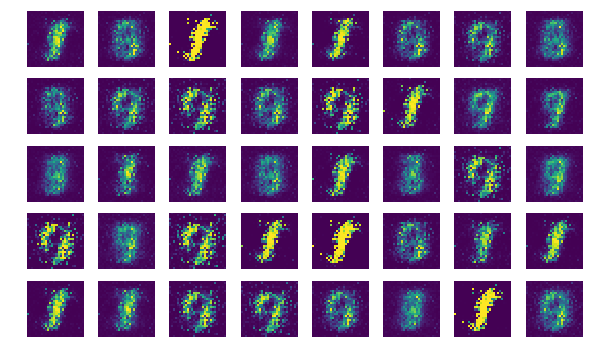

In [25]:
fig = plt.figure(figsize=(10,6))
nrow = 5
ncol = 8

for row in range(nrow):
    for col in range(ncol):
        index = ncol*row + col
        plt.subplot(nrow,ncol, index+1)
        image = images[index]
        image = image.reshape(28,28)
        plt.imshow(image)#,vmax=1,vmin=0)
        plt.axis('off')

In [ ]:
p = 'MNIST_GAN_results/Random_results/MNIST_GAN_' + str(epoch + 1) + '.png'
    fixed_p = 'MNIST_GAN_results/Fixed_results/MNIST_GAN_' + str(epoch + 1) + '.png'
    show_result((epoch+1), save=True, path=p, isFix=False)
    show_result((epoch+1), save=True, path=fixed_p, isFix=True)
    train_hist['D_losses'].append(torch.mean(torch.FloatTensor(D_losses)))
    train_hist['G_losses'].append(torch.mean(torch.FloatTensor(G_losses)))


print("Training finish!... save training results")
torch.save(G.state_dict(), "MNIST_GAN_results/generator_param.pkl")
torch.save(D.state_dict(), "MNIST_GAN_results/discriminator_param.pkl")
with open('MNIST_GAN_results/train_hist.pkl', 'wb') as f:
    pickle.dump(train_hist, f)

show_train_hist(train_hist, save=True, path='MNIST_GAN_results/MNIST_GAN_train_hist.png')

images = []
for e in range(train_epoch):
    img_name = 'MNIST_GAN_results/Fixed_results/MNIST_GAN_' + str(e + 1) + '.png'
    images.append(imageio.imread(img_name))
imageio.mimsave('MNIST_GAN_results/generation_animation.gif', images, fps=5)